In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
color_cycle = itertools.cycle(colors)

# Helper functions

In [18]:
def add_variables(dataRaw, ops):
    dataRaw["tot duration"] = sum([dataRaw["duration "+str(i)] for i in ops])
    dataRaw["tot nb uses"] = sum([dataRaw["nb uses "+str(i)] for i in ops])
    dataRaw["tot avgDuration"]=dataRaw["tot duration"]/dataRaw["tot nb uses"]
    
    for i in ops:
        dataRaw["share duration "+str(i)]=dataRaw["duration "+str(i)]/dataRaw["tot duration"]
        dataRaw["expected iter duration "+str(i)]=(dataRaw["proba "+str(i)] * dataRaw["avgDuration "+str(i)]).fillna(0)
        dataRaw["duration except "+str(i)]=dataRaw["tot duration"]-dataRaw["duration "+str(i)]

        dataRaw["improvements "+str(i)]=dataRaw["sigmas1 "+str(i)]+dataRaw["sigmas2 "+str(i)]
        dataRaw["share improvements "+str(i)]=dataRaw["improvements "+str(i)]/dataRaw["nb uses "+str(i)]
        dataRaw["improvements per time "+str(i)]=dataRaw["improvements "+str(i)]/dataRaw["duration "+str(i)]
        dataRaw["score per time "+str(i)]=dataRaw["score "+str(i)]/dataRaw["avgDuration "+str(i)]

        dataRaw["op infeasible "+str(i)]=dataRaw["sigmas6 "+str(i)]
        dataRaw["share op infeasible "+str(i)]=dataRaw["op infeasible "+str(i)]/dataRaw["nb uses "+str(i)]
        dataRaw["duration op last iter "+str(i)]=dataRaw["duration "+str(i)].diff()
        
    for i in ops:
        dataRaw["expected share duration "+str(i)]=dataRaw["expected iter duration "+str(i)]/dataRaw[["expected iter duration "+str(j) for j in ops]].fillna(0).sum(axis=1)

    return dataRaw
    

In [19]:
def print_graph(instance, runs, params, minTime, maxTime, variablesGen, variablesOp, operators):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    fig.set_size_inches(15, 6.5)

    for r in runs:
        for p in params:
            inputFile = "results/01_Evo/Evo_" + instance + "_" + p[0] + "_" + str(r) + ".txt"
            dataRaw = pd.read_csv(inputFile, sep='\t', index_col=False)
            data = add_variables(dataRaw, [1, 2, 3, 4, 5])
            dataPeriod = data[(data["time"].between(minTime, maxTime))]

            for vG in variablesGen:
                if vG[0] == 1:
                    dataPeriod.plot(x="time", y=vG[1], ax = ax1, marker='x', markersize = 5, legend=True, label = vG[1]+"_"+p[1], ylabel = vG[1], color=next(color_cycle))
                if vG[0] == 2:
                    dataPeriod.plot(x="time", y=vG[1], ax = ax2, marker='+', linestyle='--', markersize = 5, legend=True, label = vG[1]+"_"+p[1], ylabel = vG[1], color=next(color_cycle))

            for vO in variablesOp:
                if vO[0] == 1:
                    for i in operators:
                        dataPeriod.plot(x="time", y=vO[1]+" "+str(i), ax = ax1, marker='x', markersize = 5, label = vO[1]+"_"+str(i)+"_"+p[1], ylabel = vO[1])
                if vO[0] == 2:
                    for i in operators:
                        dataPeriod.plot(x="time", y=vO[1]+" "+str(i), ax = ax2, linestyle='--', marker='+', markersize = 5, label = vO[1]+"_"+str(i)+"_"+p[1], ylabel = vO[1])

    plt.xlim(left=minTime)
    ax1.set_xlabel("Time (seconds)")
    plt.show()


# Average computation times (section 5.3 Table 3)

In [29]:
import os
import statistics as stat

params = "7200_8_10_0.1_1_0.005_1e-8_100_1e-4_2_0"
operator = 1  # heuristic operator

# params = "7200_8_01_0.1_1_0.005_1e-8_100_1e-4_2_0"
# operator = 5  # heuristic operator

instances = [
"S1", "S2", "S3",
"M1", "M2", "M3",
"L1", "L2", "L3"
]
inputFiles = os.listdir("baseALNSPerIteration/")
index = pd.Index(range(1, 11), name="runs")

dfAvgDurations = pd.DataFrame([[None for _ in range(len(instances))] for _ in range(1, 11)], index = index, columns = instances)

for inputFile in inputFiles:
    if params in inputFile:
        for inst in instances:
            if inputFile.startswith("Evo_" + inst):
                dataRaw = pd.read_csv("baseALNSPerIteration/"+inputFile, sep='\t', index_col=False)
                run = int(inputFile.split("_")[-1].split(".")[0])
                dfAvgDurations.loc[run, inst] = dataRaw["avgDuration " + str(operator)].iloc[-1]

for inst in instances:
    avgCompTimes = dfAvgDurations[inst].dropna().tolist()
    print(f"Instance {inst}:")
    print(f"  Average computation time: {stat.mean(avgCompTimes):.5f} seconds")


Instance S1:
  Average computation time: 0.00019 seconds
Instance S2:
  Average computation time: 0.00020 seconds
Instance S3:
  Average computation time: 0.00021 seconds
Instance M1:
  Average computation time: 0.00030 seconds
Instance M2:
  Average computation time: 0.00029 seconds
Instance M3:
  Average computation time: 0.00032 seconds
Instance L1:
  Average computation time: 0.00056 seconds
Instance L2:
  Average computation time: 0.00055 seconds
Instance L3:
  Average computation time: 0.00064 seconds


In [21]:
# GRAPHS

instance = "LL1"
runs = [1]
params = [
    ("7200_8_11_0.1_1_0.005_1e-8_100_1e-4_2_0", "Base"),

]
minTime, maxTime = 0, 7200

operators = [
    1, 5 # both heuristic and MILP operators shown
    1 # only heuristic operator shown
    5 # only MILP operator shown
]

variablesGen = [
    # (0, "current obj"),
    (0, "tot avgDuration"),
    (0, "probdelta1"),
]

variablesOp = [
    (1, "proba"),
    (0, "score"),
    (0, "score per time"),
    (0, "weight"),
    (0, "nb uses"),
    (0, "avgDuration"),
    (0, "duration"),
    (0, "improvements"),
    (0, "share improvements"),
    (0, "improvements per time"),
    (0, "op infeasible"),
    (0, "share op infeasible"),
    (0, "expected share duration"),
    (0, "expected iter duration"),
    (0, "duration op last iter")
]

print_graph(instance, runs, params, minTime, maxTime, variablesGen, variablesOp, operators)

SyntaxError: invalid syntax (134085187.py, line 13)

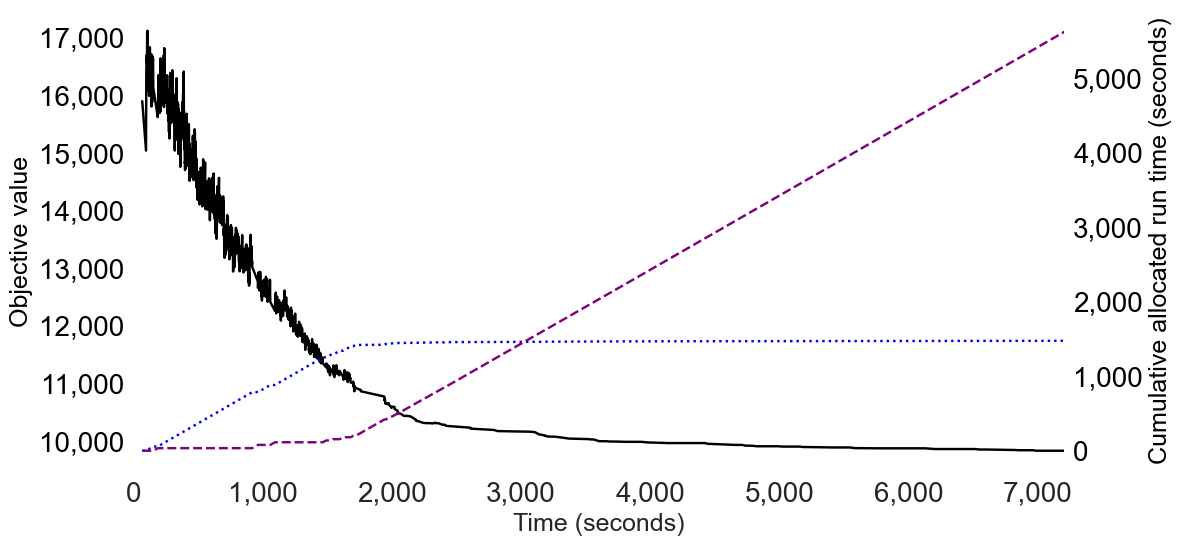

In [ ]:
# TYPICAL RUN

# plt.style.use('seaborn-v0_8-white')
plt.style.use('seaborn-v0_8')
from matplotlib.ticker import StrMethodFormatter

instance = "LL1"
params = "7200_8_10001_0_0_0_0_6_999_1_180_1_4_0_180_1_8_0_180_2_8_0_180_0.1_0.1_1_0.005_1e-8_100_1e-4_2_0"
run = 1

inputFile = "results/01_Evo/Evo_" + instance + "_" + params + "_" + str(run) + ".txt"
dataRaw = pd.read_csv(inputFile, sep='\t', index_col=False)
data = add_variables(dataRaw, [1, 2, 3, 4, 5])
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

fig.set_size_inches(12, 6)

# data.plot(x="time", y="current obj", ax = ax1, color='black', markersize = 7, legend=False, fontsize = 20)
# data.plot(x="time", y="duration 1", ax = ax2, color='black', style = ':', markersize = 7, legend=False, fontsize = 20)
# # data.plot(x="time", y="duration 2", ax = ax2, style = ':', markersize = 7, legend=False, fontsize = 20)
# # data.plot(x="time", y="duration 3", ax = ax2, style = ':', markersize = 7, legend=False, fontsize = 20)
# # data.plot(x="time", y="duration 4", ax = ax2, style = ':', markersize = 7, legend=False, fontsize = 20)
# # data.plot(x="time", y="duration 5", ax = ax2, style = ':', markersize = 7, legend=False, fontsize = 20)
# data.plot(x="time", y="duration 5", ax = ax2, color='black', style = '--', markersize = 7, legend=False, fontsize = 20)

data.plot(x="time", y="current obj", ax = ax1, color='black', markersize = 7, legend=False, fontsize = 20)
data.plot(x="time", y="duration 1", ax = ax2, color='blue', style = ':', markersize = 500, legend=False, fontsize = 20)
data.plot(x="time", y="duration 5", ax = ax2, color='purple', style = '--', markersize = 500, legend=False, fontsize = 20)

ax1.set_xlabel("Time (seconds)", fontsize=18)  # Larger X-axis label font size
ax1.set_ylabel("Objective value", fontsize=18)  # Larger Y-axis label font size
ax2.set_ylabel("Cumulative allocated run time (seconds)", fontsize=18)  # Larger secondary Y-axis label font size

ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax1.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

ax2.tick_params(axis='y', colors='black')
ax2.yaxis.label.set_color("black")  # Change to your desired color
ax2.grid(False)
ax1.tick_params(axis='y', colors='black')
ax1.yaxis.label.set_color("black")  # Change to your desired color
ax1.grid(False)

ax1.set_frame_on(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_position('zero')
ax2.set_xlim(0, 7200)

plt.show()